# NYU-CUSP Principles of Urban Informatics 2017 final

## READ THE [README](README.md) AND THE [RULES](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_RULES.ipynb) FIRST! **


There are [hints](https://docs.google.com/document/d/1lXM07wQsbxXKfCbWYP6RJlDqFOl0E1LWWzLVJ0bEmAM/edit?usp=sharing) and further details on the data in [PUI2017final_DATA](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_DATA.ipynb) 

**Motivation:**

The study of NYC crime is of broad interest in the Urban Science scene, and NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods (opportunity), and to how easy it is to commit a crime (the neighborhood safety, or perceived safety). [It has been suggested](https://journalistsresource.org/studies/government/criminal-justice/unemployment-property-crime-burglary) that unemployment correlates strongly with burglary for example, due to both opportunity and motivation. In addition there are [several pieces of research](https://www.citylab.com/solutions/2016/04/vacant-lots-green-space-crime-research-statistics/476040/) that indicate that access to green spaces affects crime.

In this final you should explore and model NYC crime:

- The first part of the exam is an exploratory analysis of the crime time series for the seven major felonies 2000-2016 (temporal domain).

- The second part of the exam attempts to relate socioeconomic features to individual crime rates by area (spatial domain).

- Lastly, if you wish, in the extra credit, you can aggregate the socioeconomic features that I indicated at the precinct level: percentage of unemployment and median income, that natively come at the census tract level from the census bureau API, and green area, for which you can use the NYC parks shapefile.


There are [hints](https://docs.google.com/document/d/1lXM07wQsbxXKfCbWYP6RJlDqFOl0E1LWWzLVJ0bEmAM/edit?usp=sharing), and partially processed datasets. Look for them. As in the midterm you can access the partially processed datasets (only one in this case) and go back to the processing task at a later time. If you then provide your own processing of the data you will be given points accordingly.


In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline

import seaborn
import urllib
import os
import geopandas as gpd

from sklearn import cluster
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

Populating the interactive namespace from numpy and matplotlib


# 1. Time domain exploratory analysis

## 1.1 obtain historical data for 2000-2016 for all NYC police precincts
you can obtain the data from NYC.gov it should be an excel file called seven-major-felony-offenses-by-precinct-2000-2016.xls

In [2]:
url = ("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/" +
             "seven-major-felony-offenses-by-precinct-2000-2016.xls")

crime = pd.read_excel(url, header=2)
crime = crime.fillna(method='ffill')

crime.head(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0


In [3]:
crime.tail(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
633,"5. On Sept. 28, 2012, there was a re-alignment...",TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
634,6. The 121 pct was created on 7-1-2013 from pa...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
635,7. As of 1-1-2014 complaints occurring within ...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0


In [4]:
crime.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000
mean,630.188679,554.213836,527.141509,499.028302,483.877358,466.738994,441.257862,417.588050,408.408805,367.578616,361.676101,368.927673,386.603774,361.996855,343.396226,338.764151,329.465409
std,886.138426,790.743142,739.370608,697.085017,675.478938,638.157402,602.084727,571.483049,556.479626,505.148518,495.912139,504.452529,533.872234,509.611397,489.177964,482.938947,473.514493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.500000,70.500000,74.500000,61.750000,56.750000,54.000000,43.500000,43.750000,42.250000,36.000000,35.000000,34.000000,33.000000,29.750000,28.750000,29.750000,28.000000
50%,361.000000,315.500000,305.500000,277.500000,279.000000,275.500000,254.000000,228.000000,222.500000,208.000000,196.500000,200.500000,205.000000,177.000000,169.500000,163.500000,141.500000
75%,648.250000,581.000000,561.500000,524.750000,496.250000,514.250000,475.000000,475.000000,460.000000,414.000000,396.250000,413.000000,435.000000,415.000000,413.000000,379.000000,425.250000
max,6857.000000,6088.000000,5265.000000,5105.000000,4730.000000,4423.000000,4173.000000,3971.000000,3708.000000,3330.000000,3103.000000,3393.000000,3780.000000,3902.000000,3751.000000,3506.000000,3287.000000


## 1.2 remove outliers (likely wrongly input data)


In the data I downloaded (last download yesterday) there was a wrong set of rows for one precinct. You should be able to see it when you plot the time series. The values are obviously wrong (extremely large for all crimes). 



In [5]:
crime.drop(range(616, len(crime)), axis=0, inplace=True)
crime.tail(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
613,123,GRAND LARCENY,101.0,90.0,116.0,137.0,166.0,233.0,175.0,181.0,191.0,171.0,147.0,175.0,183.0,171.0,194.0,163.0,145.0
614,123,GRAND LARCENY OF MOTOR VEHICLE ...,266.0,193.0,143.0,131.0,95.0,96.0,114.0,87.0,81.0,51.0,39.0,48.0,31.0,40.0,30.0,20.0,23.0
615,123,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,378.0,348.0,302.0


In [6]:
# Values for crime.iloc[592:600][crime.columns[2:15]] are missing from the original data,
# and were filled with overly large values when we performed a forward fill. I initiall tried:
# crime.replace(crime.iloc[592:600][crime.columns[2:15]], np.nan, inplace=True)
# but this also effected row 591 (the row it was filled from), so I settled for the less efficient
# method below. 

crime.iloc[592:600][crime.columns[2:15]] = np.nan
crime.iloc[590:602]

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alexandershannon/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
590,120,GRAND LARCENY OF MOTOR VEHICLE ...,476.0,328.0,320.0,243.0,246.0,228.0,247.0,218.0,209.0,214.0,192.0,169.0,166.0,94.0,73.0,79.0,94.0
591,120,TOTAL SEVEN MAJOR FELONY OFFENSES,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,1601.0,1165.0,1147.0,1131.0
592,121,MURDER & NON NEGL. MANSLAUGHTER ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,0.0,9.0
593,121,RAPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,13.0,19.0
594,121,ROBBERY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,151.0,138.0,120.0
595,121,FELONY ASSAULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,225.0,248.0,190.0
596,121,BURGLARY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,134.0,166.0,137.0
597,121,GRAND LARCENY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.0,393.0,430.0,397.0
598,121,GRAND LARCENY OF MOTOR VEHICLE ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,60.0,74.0,63.0
599,121,TOTAL SEVEN MAJOR FELONY OFFENSES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548.0,979.0,1069.0,935.0


In [7]:
# more cleaning

# make all columns integers
int_col_names = np.array([int(i) for i in crime.columns[2:]])
new_cols = dict(zip(crime.columns[2:], int_col_names))
crime.rename(columns=new_cols, inplace=True)

# make crime names simpler for analysis
crimes_simple = ['murder_and_non_negl_manslaughter', 'rape', 'robbery', 'felony_assault', 'burglary', 
                 'grand_larceny', 'grand_larceny_motor_vehicle', 'total_seven_maj_felonies']
new_crimes = dict(zip(crime.CRIME.unique(), crimes_simple))
crime.CRIME.replace(new_crimes, inplace=True)

# PCT to string, to make plotting easier
crime.PCT = crime.PCT.astype(str)
crime.set_index('PCT', inplace=True)

crime.tail(3)

,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
PCT,,,,,,,,,,,,,,,,,,
123,grand_larceny,101.0,90.0,116.0,137.0,166.0,233.0,175.0,181.0,191.0,171.0,147.0,175.0,183.0,171.0,194.0,163.0,145.0
123,grand_larceny_motor_vehicle,266.0,193.0,143.0,131.0,95.0,96.0,114.0,87.0,81.0,51.0,39.0,48.0,31.0,40.0,30.0,20.0,23.0
123,total_seven_maj_felonies,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,378.0,348.0,302.0


## 1.3  Plot the time series for each of the seven major felonies and for the total (aggregation of all felonies). 
There is a lot of data to plot. See the hints on how to get the time series to plot for the dataframe if you want to, or extract the data and plot with pylab. But be thoughtful about how you organize the display of information.
This will help you spot the wrong rows if you do it before the outlier rejection (that is how I realized there was an outlier). Make sure your plot shows the clean dataset though. 

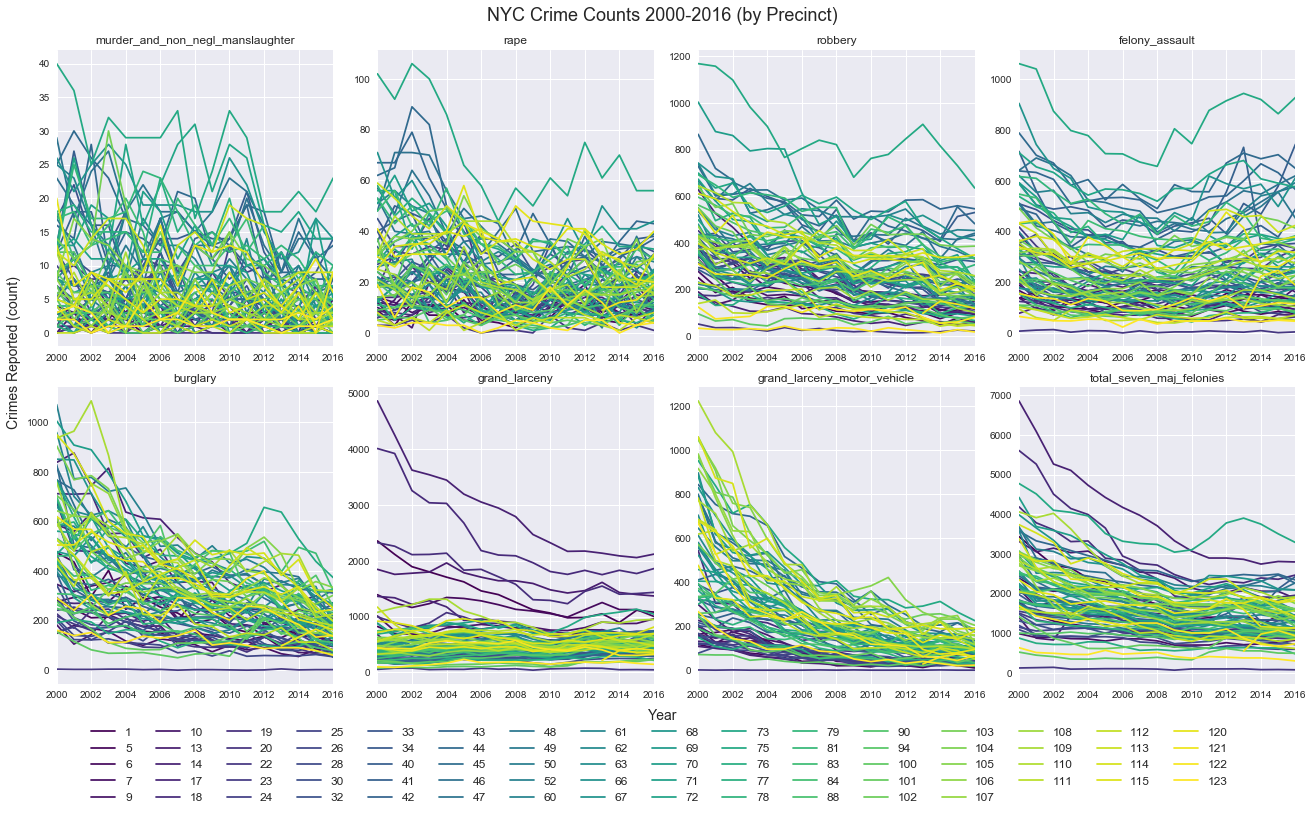

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4)
for i, j in enumerate(crime.CRIME.unique()):
    crime[crime.CRIME == j].T.iloc[1:].plot(ax=axes.flat[i], legend=False, figsize=(18,10),
                                           colormap='viridis').set_title(j)

fig.text(0.5, -0.005, 'Year', ha='center', va='center', fontsize=14)
fig.text(0, 0.5, 'Crimes Reported (count)', ha='center', va='center', rotation='vertical', fontsize=14)
pl.legend(loc=9, bbox_to_anchor=(-1.3, -0.11), fontsize=12, ncol=16) 
pl.suptitle('NYC Crime Counts 2000-2016 (by Precinct)', fontsize=18)
pl.tight_layout()
fig.subplots_adjust(top=0.92)

**Figure 1:** There are no major outliers in this plot (I noticed and removed the error in the forward-fill in the last section), but we still do see some interesting trends. While the individual precincts are too compacted to make out in these plots (using something like the 'plotly' library would be really useful, but not allowed on this exam), I chose 'viridis' as a colormap (presents a good scheme of colors and is colorblind-friendly!), allowing a general visualization for groupings of precincts (which are spatially grouped together - http://www.sociology101.net/marijuana-arrests/images/NYC-precincts-by-race.jpg - ignore the marajuana arrests, it's just a good map!). This reveals some surface trends; for example, grand larceny is particularly present in the lower precincts (which correspond to downtown Manhattan) and violent crimes (murder, rape, felony assult) tend to be more prevelant in middle-numbers (corresponding to Bronx and Brooklyn). From a more over-arching perspective, crime is going down across the board in New York City, likely making some police cheifs very happy.

## 1.4 calculate the mean and standard deviation in time for each precinct and each crime

In [9]:
crime.index = crime.index.astype(int)
crime['PCT'] = crime.index
crime_mean_std = crime.groupby(['PCT','CRIME']).mean()
crime.drop('PCT', axis=1, inplace=True)
crime_mean_std['mean'] = crime_mean_std.mean(axis=1)
crime_mean_std['st_dev'] = crime_mean_std[crime_mean_std.columns[:-1]].std(axis=1)
crime_mean_std = crime_mean_std[crime_mean_std.columns[-2:]]
crime_mean_std.head(20)

mean      st_dev
PCT CRIME                                                    
1   burglary                           242.176471  107.459431
    felony_assault                     104.882353   28.676825
    grand_larceny                     1406.705882  440.662536
    grand_larceny_motor_vehicle         81.470588   53.396065
    murder_and_non_negl_manslaughter     1.058824    0.966345
    rape                                 8.588235    3.063063
    robbery                            125.705882   56.514118
    total_seven_maj_felonies          1970.588235  674.856379
5   burglary                           152.941176   57.669826
    felony_assault                     130.941176   28.560179
    grand_larceny                      616.823529   79.120348
    grand_larceny_motor_vehicle         45.882353   34.521519
    murder_and_non_negl_manslaughter     1.882353    1.317306
    rape                                 7.529412    3.429972
    robbery                            147.058824   67.217437
    total_seven_maj_felonies          1103.058824  233.630443
6   burglary                           225.588235   73.271805
    felony_assault                     114.352941   20.322221
    grand_larceny                     1183.000000  116.800043
    grand_larceny_motor_vehicle         82.117647   57.636666

### EC1 - you can do a quantitative analysis of these time series (trends, periodicity etc.). But I recommend you only do it after you proceed to the other mandatory tasks. 

#### Event Detection
It's said that when the Beatles played on the Ed Sullivan Show in 1963, there was no reported crime in NYC during their performance (so either nobody was commiting crimes, or people were too distracted to report it!). While our data are annual, and so wouldn't pick up on this kind of thing, are their any outliers that we should be aware of? Perhaps people were particularly peaceful when the city came together after 9/11? Or particularly violent in wake of the Yankees' tragic loss to the Marlins in the 2003 World Series? Let's investigate.

In [10]:
event_detect = crime.reset_index(level=0)

# Let's look by borough, as that will give more detail than NYC as
# a whole, but not get as lost in the weeds as individual precincts.

# Precinct Codes: Manhattan 1-34 ; Bronx 40-52 ; Brooklyn 60-94
# Queens 100-115 ; Staten Island 120-120

pct_codes = event_detect.PCT
boroughs = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens',
            5: 'Staten Island'}
borough_code = [1 if i <=34 else 2 if i <=52 else 3 if i <=94 else 4 if i <=115 else 5 \
            for i in pct_codes]
borough_name = [boroughs[i] for i in borough_code]

event_detect['borough_name'] = borough_name

event_detect.drop(['PCT'], axis=1, inplace=True)
event_detect = event_detect.groupby(['borough_name', 'CRIME']).sum()

event_detect['mean'] = event_detect.mean(1)
event_detect['std'] = event_detect.std(1)

event_detect.head(10)

2000     2001     2002  \
borough_name CRIME                                                         
Bronx        burglary                           7440.0   5822.0   5193.0   
             felony_assault                     6196.0   5565.0   5143.0   
             grand_larceny                      4584.0   4334.0   4798.0   
             grand_larceny_motor_vehicle        6517.0   5457.0   5210.0   
             murder_and_non_negl_manslaughter    190.0    191.0    171.0   
             rape                                507.0    518.0    570.0   
             robbery                            6123.0   5289.0   5215.0   
             total_seven_maj_felonies          31557.0  27176.0  26300.0   
Brooklyn     burglary                          12665.0  10962.0  10351.0   
             felony_assault                     9330.0   8390.0   7410.0   

                                                  2003     2004     2005  \
borough_name CRIME                                                         
Bronx        burglary                           5136.0   4872.0   4218.0   
             felony_assault                     4643.0   4541.0   4366.0   
             grand_larceny                      4781.0   5052.0   5373.0   
             grand_larceny_motor_vehicle        4770.0   4516.0   4117.0   
             murder_and_non_negl_manslaughter    136.0    126.0    129.0   
             rape                                531.0    402.0    374.0   
             robbery                            5170.0   5076.0   5057.0   
             total_seven_maj_felonies          25167.0  24585.0  23634.0   
Brooklyn     burglary                           9650.0   9116.0   8144.0   
             felony_assault                     6760.0   6459.0   6358.0   

                                                  2006     2007     2008  \
borough_name CRIME                                                         
Bronx        burglary                           3941.0   3889.0   3557.0   
             felony_assault                     4407.0   4408.0   4105.0   
             grand_larceny                      5314.0   5387.0   5282.0   
             grand_larceny_motor_vehicle        3399.0   3002.0   2943.0   
             murder_and_non_negl_manslaughter    155.0    130.0    132.0   
             rape                                336.0    318.0    308.0   
             robbery                            4933.0   4609.0   4845.0   
             total_seven_maj_felonies          22485.0  21743.0  21172.0   
Brooklyn     burglary                           7691.0   7157.0   7027.0   
             felony_assault                     6061.0   6078.0   5573.0   

                                                  2009     2010     2011  \
borough_name CRIME                                                         
Bronx        burglary                           3637.0   3342.0   3533.0   
             felony_assault                     4333.0   4439.0   4456.0   
             grand_larceny                      4847.0   4682.0   4898.0   
             grand_larceny_motor_vehicle        2413.0   2162.0   2088.0   
             murder_and_non_negl_manslaughter    113.0    127.0    148.0   
             rape                                269.0    288.0    274.0   
             robbery                            4129.0   4610.0   4578.0   
             total_seven_maj_felonies          19741.0  19650.0  19975.0   
Brooklyn     burglary                           6516.0   6638.0   6291.0   
             felony_assault                     5715.0   5711.0   6595.0   

                                                  2012     2013     2014  \
borough_name CRIME                                                         
Bronx        burglary                           3163.0   2949.0   2858.0   
             felony_assault                     4836.0   5467.0   5190.0   
             grand_larceny                      5545.0   6048.0   5954.0   
             grand

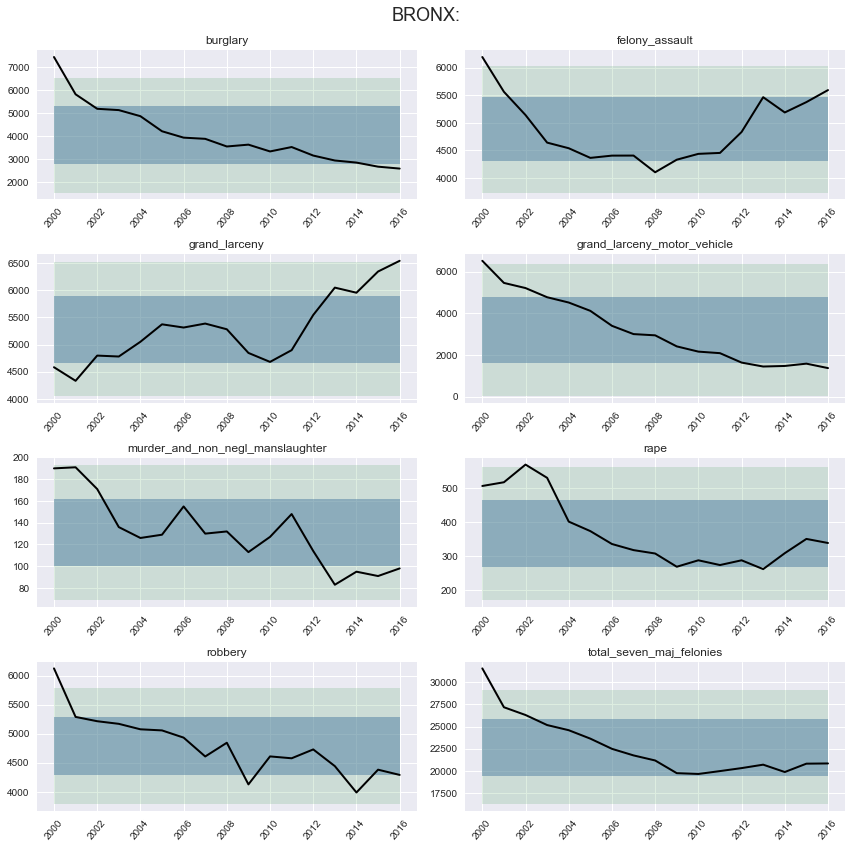

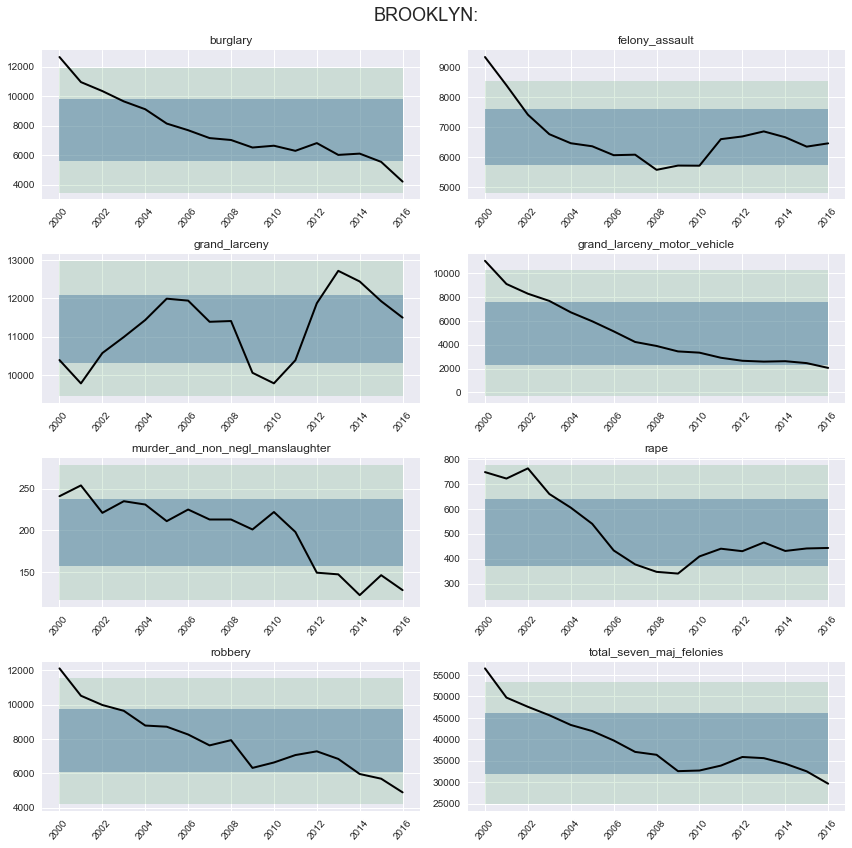

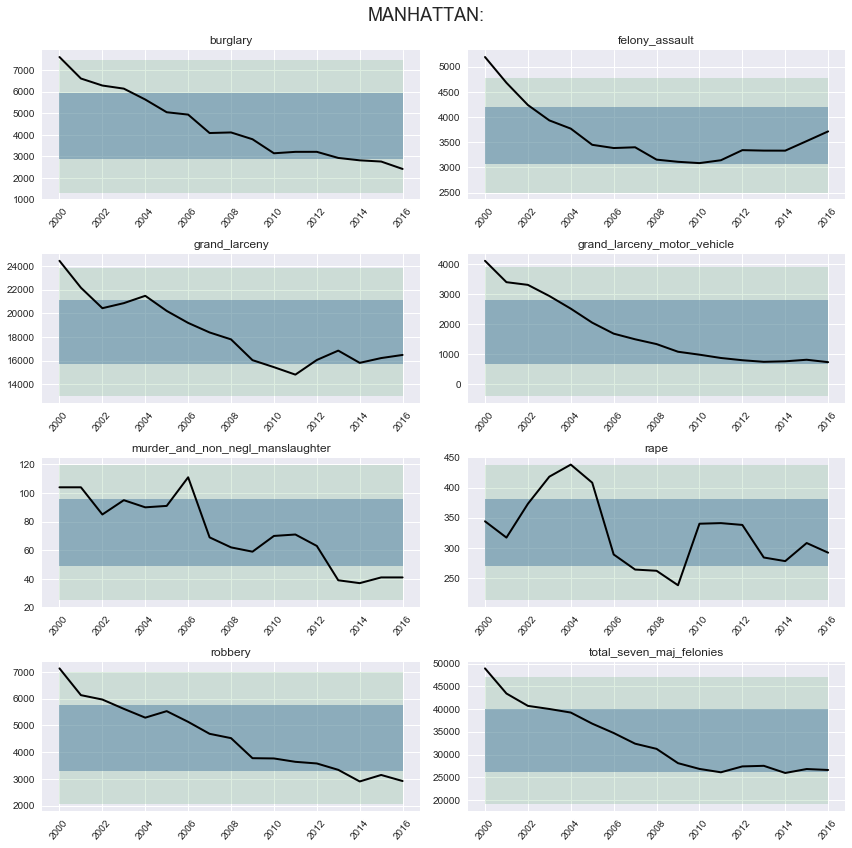

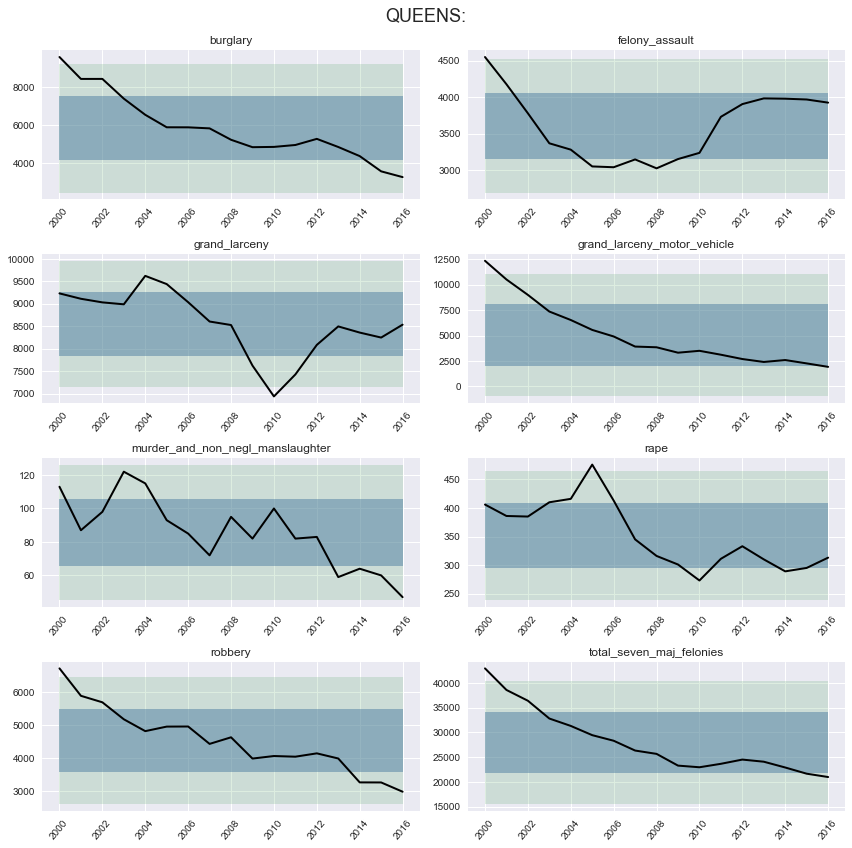

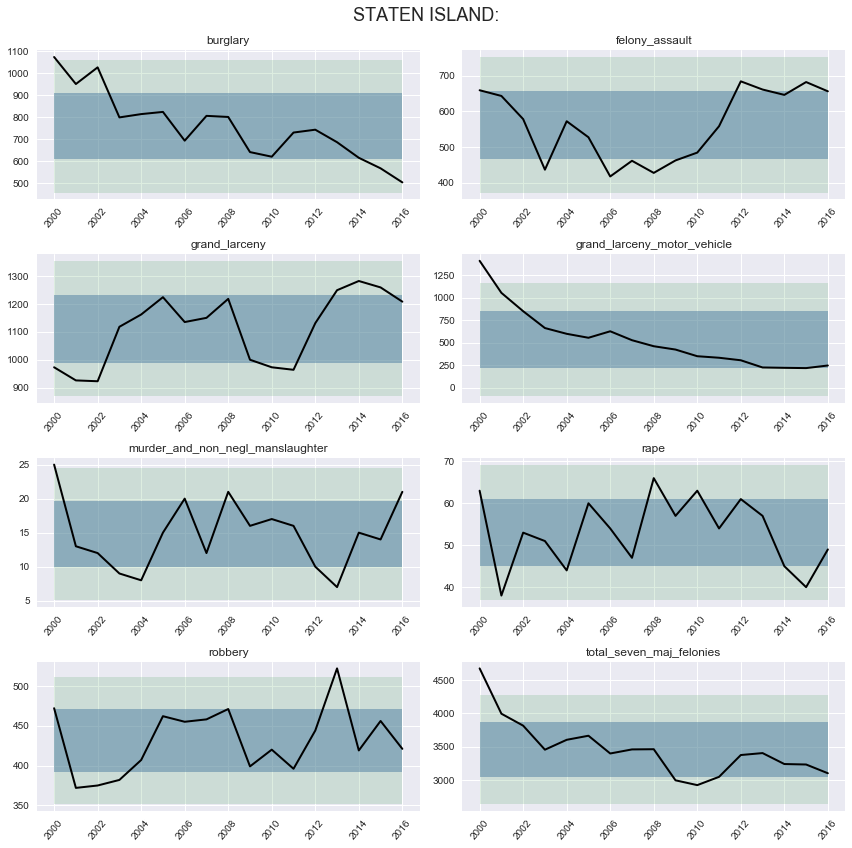

In [11]:
boroughs_unique = event_detect.index.get_level_values(0).unique()
crimes_unique = event_detect.index.get_level_values(1).unique()

# Apologies for the double for-loop, but I think it actually makes sense here.
# I would be curious to know if there's a more efficient way to plot these.
for i in boroughs_unique:
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
    
    for j, k in enumerate(crimes_unique):
        # set appropriate values & thresholds
        crime_series = event_detect.loc[i].loc[k][:-2]
        crime_series_mean = event_detect.loc[i].loc[k][-2]
        crime_series_std = event_detect.loc[i].loc[k][-1]
        series_mean = [crime_series_mean for n in crime_series]
        year = [year for year in event_detect.columns[:-2]] 
        onesig = crime_series_std
        tsthresh_neg = crime_series_mean  - 2 * onesig
        tsthresh_pos = crime_series_mean  + 2 * onesig

        # plot creation and formatting
        pl.subplot(4,2,j+1)
        pl.fill_between(year, series_mean - onesig,
                        series_mean + onesig, alpha=0.5)
        pl.fill_between(year, series_mean - 2 * onesig, 
                        series_mean + 2 * onesig, alpha = 0.2);
        pl.plot(year, crime_series, 'k-', lw = 2)
        pl.xticks(rotation = 50, fontsize=10)
        pl.tight_layout()
        pl.title(k)
    
    pl.suptitle(i.upper() + ':', fontsize=18)
    fig.subplots_adjust(top=0.93)

**Figure 2:** The above subplots attempt to identify exceptional years in each borough. Our definition of exceptional will be anything over 2 standard deviations from the mean. The main unifying theme among nearly all of the graphs in all of the boroughs is that they are going downwards with time - grand larceny in the Bronx is really the only instance in stark contrast to this trend, displaying a clear rising trend. While no single years stand out as stark outliers (robbery in Staten Island in 2013, for instance, is an outlier, but that trend does not carry over to other crimes or boroughs), every single borough's 'Total of Seven Major Felonies' starts out over 2 standard deviations above the mean, and drops to approximately one standard deviation below the mean (some slightly higher, some slightly lower). This is an incredible drop to see in a decade and a half for any city, and shows no signs (at least with the data we have) of reversing. This largely indicates that New York is a safer place to be these days (assuming 2016 numbers haven't changed too much) than in 2000. Indeed, the only type of crime that has seen an uptick from 2000 is grand larceny, which could be indicitive of growing inequality lurking beneath the surface of this city.

## 1.5 extract the total crime row for each precinct and cluster the time series. Plot the clusters and discuss the clustering and the trends that you see. 
(as done in HW10 and 11, see [tips on clustering](https://github.com/fedhere/PUI2017_fb55/blob/master/final/preprocessinANDclustering.ipynb))
I am not looking for a particularly rigorous clustering analysis here, so you do not need to obsess over the right number of clusters for example, or the exact density for DBscan. However, once the clusters are done, visualize them, and make sure that they are convincing clusters that do display homogeneous trends that are different for the different clusters.

In [12]:
totcrime = crime.iloc[7::8]
totcrime['mean'] = totcrime[totcrime.columns[1:]].T.mean()
totcrime['stdev'] = totcrime[totcrime.columns[1:-1]].T.std()
totcrime.head(3)

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,mean,stdev
PCT,,,,,,,,,,,,,,,,,,,,
1,total_seven_maj_felonies,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0,1970.588235,674.856379
5,total_seven_maj_felonies,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,1029.0,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0,1103.058824,233.630443
6,total_seven_maj_felonies,2387.0,2141.0,2059.0,2068.0,2174.0,2055.0,1979.0,1837.0,1738.0,1633.0,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0,1815.647059,294.198900


In [13]:
# normalizing the values for clustering
cluster_crime = totcrime[totcrime.columns[1:]].dropna()
cluster_crime = cluster_crime[cluster_crime.columns[:-2]]
vals = ((cluster_crime.T - cluster_crime.mean(1)) / cluster_crime.std(1)).T

#perform k-means clustering and add column to dataframe
Nc = 5
km = cluster.KMeans(n_clusters=Nc, random_state=123)
km.fit(vals)
vals['cluster'] = km.labels_
vals.head(3)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
PCT,,,,,,,,,,,,,,,,,,
1,2.174406,1.627623,1.103067,1.005268,0.611110,0.495530,0.062846,-0.083852,-0.389102,-0.581736,-0.778815,-0.842532,-0.821787,-0.821787,-1.130001,-0.777333,-0.852905,3
5,2.897487,1.519242,0.881483,0.547622,0.286526,0.119596,-0.269908,-0.308431,-0.316991,-0.548126,-0.573807,-0.603769,-0.436839,-0.526724,-0.997553,-0.796381,-0.873426,1
6,1.942063,1.105894,0.827171,0.857763,1.218063,0.813575,0.555247,0.072580,-0.263927,-0.620828,-0.970932,-1.059307,-0.821373,-0.382894,-0.817974,-1.001523,-1.453598,3


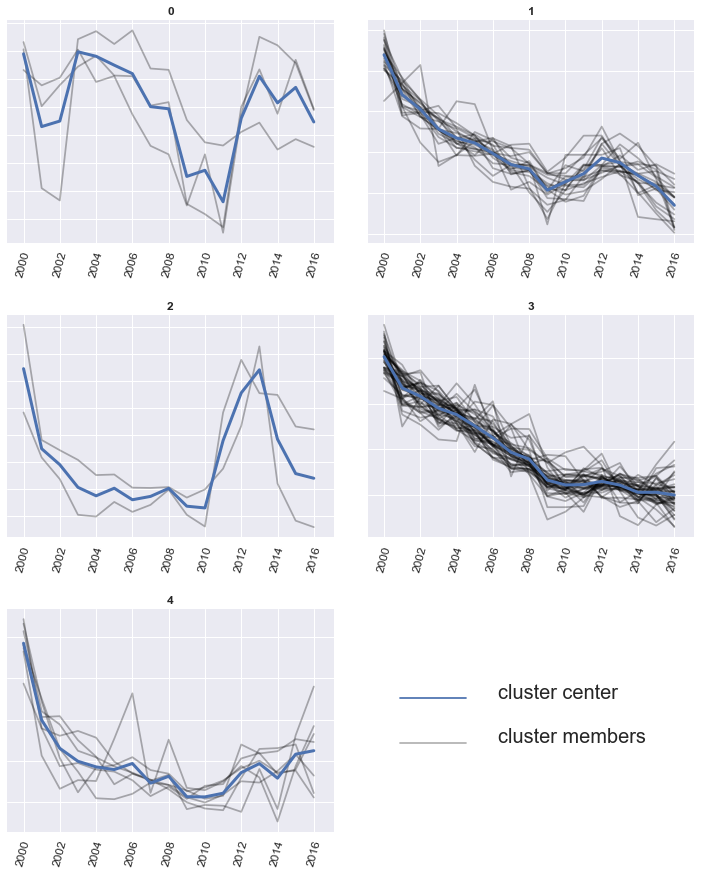

In [14]:
# Just to give credit - much of this comes from the HW #11 solution file!
# Without it I would have had a much more difficult time of grappling with this
# though it was admitidly still quite tricky - though great practice. 

timeline = pd.date_range('2000', '2017', freq='A')

fig = pl.figure(figsize=(10, 20))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))

    for v in vals[vals.cluster == i].T:
        y = vals.loc[v][:-1]
        ax.plot(np.arange(2000, 2017, 1), y, 'k-', alpha=0.3)

    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    ax.plot(np.arange(2000, 2017, 1), Xc, lw=3)
    pl.xticks(fontsize=12, rotation=75)
    pl.title(i, fontweight='bold')
    ax.set_xlim(1999.1, 2017.1)

ax = fig.add_subplot(5, 2, i + 2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], 'k-', alpha=0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], '-')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
tmp = ax.axis('off')
pl.tight_layout()

**Figure 3:** The above cluster analysis groups the precincts into 5 distinct categories using k-means clustering. Clusters 0 & 2 both see a sharp rise after 2012, bucking the trend of the vast majority of other precincts, which go down throughout. Clusters 1 & 3 had primarily downward trends and contain a considerable amount more precincts than 0, 2, & 4.

# Part 2: connecting the temporal and spatial components.
## 2.1 obtain the NYC precincts geometry and read it in as a shapefile           
(see [the data tips](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_DATA.ipynb))

In [15]:
if os.path.isfile('nypp_17d.zip'):
    print ('File already loaded - you\'re good to go!')
else:
    !wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17d.zip
    !unzip nypp_17d.zip
    print('\nFile has successfully loaded. Rock on.')

/bin/sh: wget: command not found
unzip:  cannot find or open nypp_17d.zip, nypp_17d.zip.zip or nypp_17d.zip.ZIP.

File has successfully loaded. Rock on.


In [16]:
precincts = gpd.GeoDataFrame.from_file("nypp_17d/nypp.shp")
precincts = precincts.set_index('Precinct')
precincts.plot(color='white', edgecolor='k', figsize=(8,8));

OSError: no such file or directory: 'nypp_17d/nypp.shp'

**Figure 4:** This is New York City, graphed spatially and seperated by police precinct. 

## 2.2 merge the precincts geodataframe with the dataframe of crime that you used to cluster the time series and plot a choropleth of the clusters. 
Discuss if you see spatial coherence - does the geographical information help interpret the trends you see in time domain?

/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/core/indexes/base.py:2598: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/core/indexes/base.py:1642: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


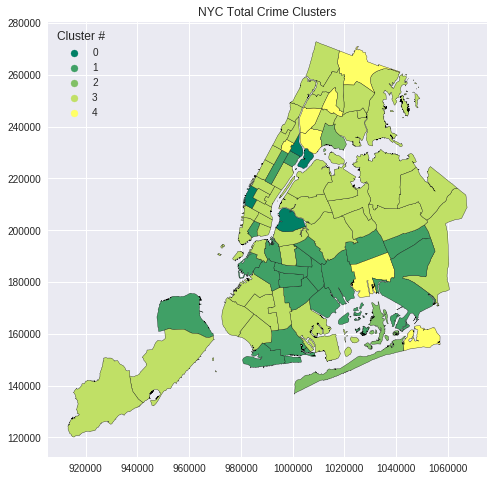

In [17]:
cluster_merge = precincts.merge(vals, how='inner', left_index=True, right_index=True)

graph = cluster_merge.plot(column='cluster', cmap='summer', figsize=(8,8), 
                           scheme='equal_interval', k=5, edgecolor = 'k', legend=False);

# adding a legend manually, as these are discrete values, and pylab returns a 
# range, which can be confusing to a viewer.
cmap = matplotlib.cm.get_cmap('summer')
colors = [cmap(i) for i in np.arange(0, 1.25, 1.26/5)] # creates corresponsing color values
for i in range(5):
    plt.scatter([], [], c=colors[i], label=i)
plt.legend(loc=2, title='Cluster #')

pl.title('NYC Total Crime Clusters');

**Figure 5:** Above, we see the clusters we graphed in Figure 3 from a spatial view. There do seem to be weak spatial groupings, indicating that location may have some inpact on crime trends over the time-period, however it's worth noting that there are a number of groupings that do not align very much, and so we should be cautious before drawing any conclusions. It is also worth noting that part of Statten Island is missing here, because this had missing values that needed to be dropped before performing the clustering analysis, therefore it is excluded.

### EC2 visualize each crime by precinct. here you can choose the visual display that you prefer, but not a time series plot (like you did before) or a coropleth (like you will do later). It could be a box and whiskers plot for example

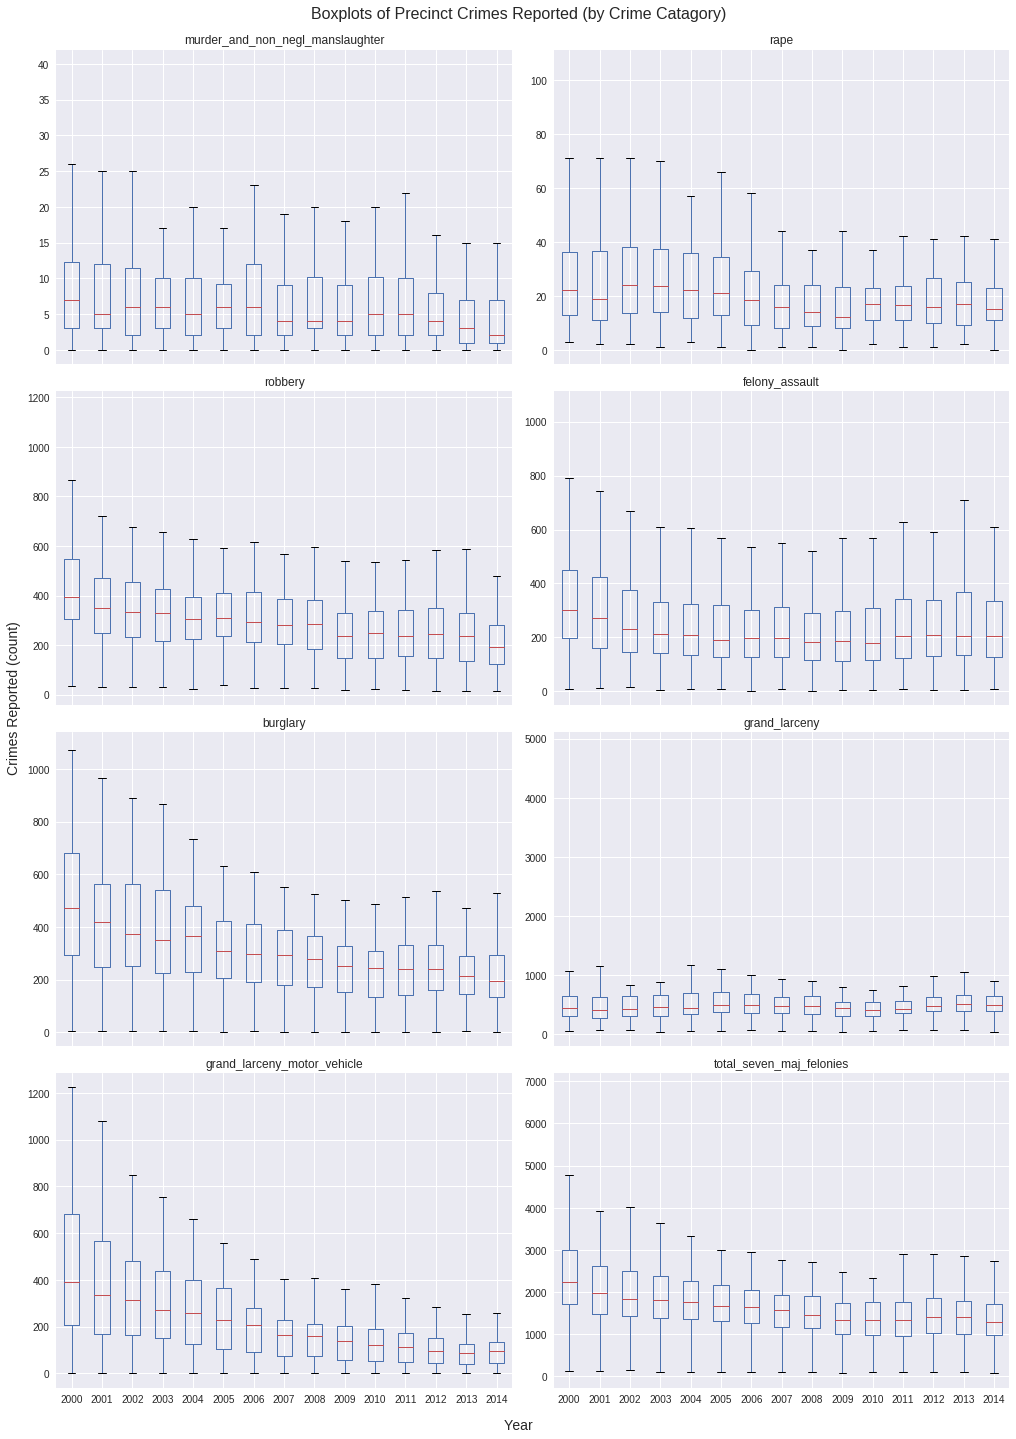

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20), sharex=True)

for i, j in enumerate(crime.CRIME.unique()):
    crime[crime.CRIME == j][crime.columns[1:-2]].boxplot(ax=axes.flat[i]).set_title(j)

fig.text(0.5, -0.005, 'Year', ha='center', va='center', fontsize=14)
fig.text(0, 0.5, 'Crimes Reported (count)', ha='center', va='center', rotation='vertical', fontsize=14)
pl.xticks(fontsize=10)
pl.suptitle('Boxplots of Precinct Crimes Reported (by Crime Catagory)', fontsize=16)
pl.tight_layout()
fig.subplots_adjust(top=0.95)

**Figure 6:** The above box plots show trends hinted at in the time series plots (Figure 1) in a much clearer light. We can see trends in both minimum and maximum crime counts, as well as in the median and inner quartile range. We can see that while there is a general downward trend across the board, it is more pronounced for some crimes (e.g. "Grand Larceny - Motor Vehicle") and less pronounced or even non-existant in others (e.g. "Grand Larceny (Non-Motor-Vehicle)"); Perhaps the city has implimented an effective policy that has detered car theifs but hasn't had positive spillover into other areas of theft? This warrants further investigation.

## 2.3 download the data containing the socioeconomic features to be used as exogenous variables. 
I prepared a file with socioeconomic features for each precinct: unemployed fraction, median income, fraction of the precinct area that is green. Dowload it from https://nyu.carto.com via sql (HW 7) ( ideally only extracting the relevant columns). The source sql is  'https://fb55.carto.com:443/api/v2/sql?q=' , the name of the file  *nycsocioeconomicsbyprecinct*


In [19]:
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='
from __future__ import print_function

import urllib2
import urllib
import StringIO
import ast
import pandas as pd

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [20]:
select_factors = '''
SELECT precinct, green, medianincome, unemployment
FROM nycsocioeconomicsbyprecinct
'''

In [21]:
socioeconomics = pd.read_csv(StringIO.StringIO(queryCartoDB(select_factors)), sep=',')
socioeconomics = socioeconomics.set_index('precinct')
socioeconomics.head(3)

,green,medianincome,unemployment
precinct,,,
1,0.058702,124092.068749,0.021444
60,0.173512,35015.008703,0.056448
61,0.238375,65998.923662,0.055458


## 2.4 *pivot* the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns 
This task may be the most unfamiliar. look at the hints for an example on how to do it. If this fails you can download the pivoted file [here](https://github.com/fedhere/PUI2017_fb55/blob/master/final/crimepivoted.csv)

In [22]:
crime['avg'] = crime[crime.columns[1:]].mean(axis=1)
crime['PCT'] = crime.index.astype(int)
crimepivot = crime.pivot(index='PCT', columns='CRIME', values='avg')
crimepivot.head(3)

CRIME,burglary,felony_assault,grand_larceny,grand_larceny_motor_vehicle,murder_and_non_negl_manslaughter,rape,robbery,total_seven_maj_felonies
PCT,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059


## 2.5 merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct
clean up your data so that the only columns left are the 7 felonies, the total number of felonies, and the socioeconomic features (unemployment, median income, park access). I recommend you rename the crime features: the dataframes have very annoying white spaces encoded in them. See the hints file to remove them.

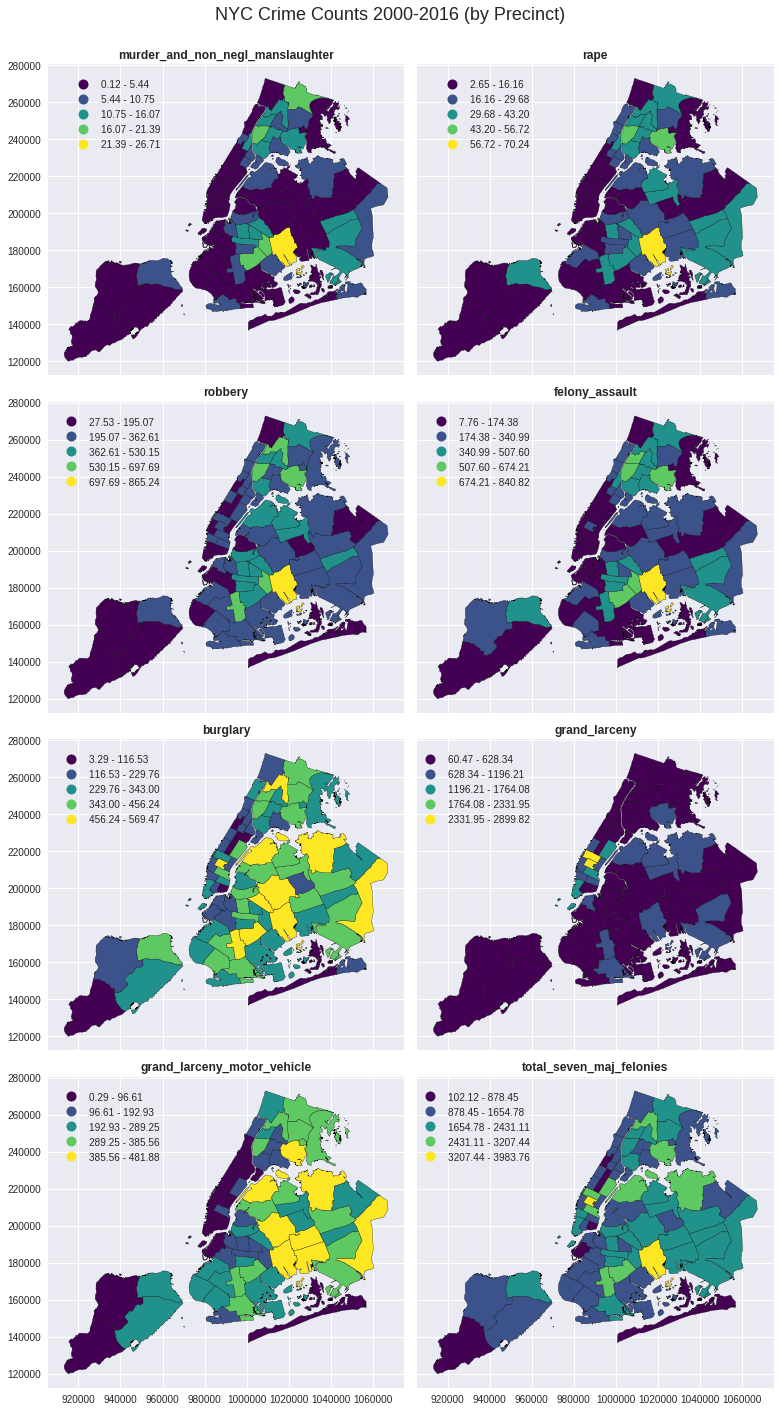

In [23]:
# make sure to use gdf as the first part of merges to maintain geodataframe
merge_temp = precincts.merge(socioeconomics, how='inner', left_index=True, right_index=True)
merged_gdf = merge_temp.merge(crimepivot, how='inner', left_index=True, right_index=True)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11,20), sharex=True, sharey=True)
for i, j in enumerate(crime.CRIME.unique()):
    graph = merged_gdf.plot(ax=axes.flat[i], column=j, cmap='viridis', edgecolor='k',
                    scheme='equal_interval', k=5, legend=True).set_title(j, fontweight='semibold') 
    leg = axes.flat[i].get_legend()
    leg.set_bbox_to_anchor((0.34, 0.98, 0, 0))

pl.suptitle('NYC Crime Counts 2000-2016 (by Precinct)', fontsize=18)
pl.tight_layout()
fig.subplots_adjust(top=0.94)

**Figure 7:** We see a spatial display of the means of the data explored temporally in Figure 1. Correspondingly, we can identify the 75th Precinct in Brooklyn (yellow in all graphs, save grand larceny) as the highest line in many of the plots in Figure 1; this is certainly an outlier. quick Google search reveals that the 75th Precinct has a reputation and history for crime and drug violence - it was the epicenter of the 1980s crack epidemic, has had more lawsuits filed against the police department than any other precinct by far, and has had a movie made about its crime (see links below).
Beyond this, we see that grand larceny of non-motor-vehicles is mostly concentrated in downtown Manhattan; because this is much more common than other crimes, the total of the 7 factors portrays midtown Manhattan as a crime hotspot, which is likely unfair, given its very low rates on other crimes, especially violent crime. While the timeseries plot of the total crime may have been useful to see the downward trend, graphing the total of all crimes spatially, as done in the last figure, may not be so useful, as it has no measure of severity - therefore it is best to look at the first seven graphs individually.
<br>Recent article on 75th Precint: http://www.nydailynews.com/new-york/cops-east-new-york-75th-precinct-sued-47-times-year-article-1.2691611<br>
Movie on 75th Precinct: http://www.imdb.com/title/tt4136056/


## 2.6 cluster the data first using the socioeconomic features and then using the 7 felonies 
You can use a simple Euclidean distance, since these are all numerical features, which is the default for most packages, or define your distance. if you do that, which would be exciting, please justify your distance definition. Mind the preprocessing! Do the clusters make sense?, is the grouping preserved? are the outliers outliers in both clustering schemes?

#### Socioecomonic Clustering

In [24]:
# normalize for clustering
socioecon_cols = socioeconomics.columns
cluster_socio = merged_gdf[socioecon_cols].dropna()
socio_vals = ((cluster_socio - cluster_socio.mean()) / cluster_socio.std())

# perform k-means, then add cluster values to dateframe
Nc_socio = 5
km = cluster.KMeans(n_clusters=Nc_socio, random_state=123)
km.fit(socio_vals)
socio_clusters = km.labels_
socio_vals['cluster'] = socio_clusters

unique, counts = numpy.unique(socio_clusters, return_counts=True)
counts_by_socio_cluster = dict(zip(unique, counts))
print('Counts by Socioeconomic Cluster:', counts_by_socio_cluster)
socio_vals.head(3)

Counts by Socioeconomic Cluster: {0: 12, 1: 30, 2: 14, 3: 20, 4: 1}


,green,medianincome,unemployment,cluster
1,-0.363027,1.788180,-1.158008,2
5,-0.430574,1.108097,-0.362904,2
6,-0.531508,1.664751,-0.884142,2


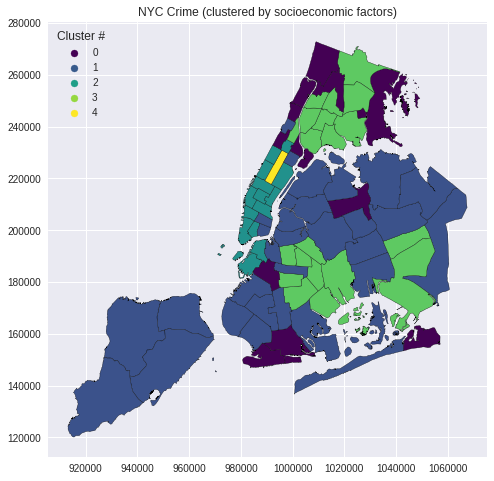

In [25]:
socio_cluster_gdf = precincts.merge(socio_vals, how='inner', left_index=True, right_index=True)
socio_cluster_gdf.plot(column='cluster', cmap='viridis', figsize=(8,8),
                       edgecolor='k', scheme='equal_interval', legend=False);

cmap = matplotlib.cm.get_cmap('viridis')
n, m = Nc_socio, 1.3
colors = [cmap(i) for i in np.arange(0, m, (m + 0.1) / n)] # creates corresponsing color values
for i in range(n):
    plt.scatter([], [], c=colors[i], label=i)
plt.legend(loc=2, title='Cluster #')

pl.title('NYC Crime (clustered by socioeconomic factors)');

**Figure 8:** Here we've clustered the socioeconomic data by greenspace, medium income, and unemployment. Through trail and error, we've come to 5 clusters, which appear to have fairly strong spatial correlation. The obvious outlier in this group is Central Park, which has absurdly high greenspace and scewed figures for income and unemployment, as there are so few people who live there (about 25, according to the census - http://www.nytimes.com/2011/03/26/nyregion/26census.html). Beyond this, we see similar groupings for Manhattan and just across the Brooklyn Bridge. It is perhaps surprising that the Lower East Side, much of Queens, and all of Statten Island fall into the same group. Even more surprisingly, using more clusters does not seperate these in any convincing way. Some further research into their similarities with regards to our variables could prove interesting. 

#### Felony Clustering

In [26]:
# normalize for clustering
felony_cols = crime.CRIME.unique()[:-1]
cluster_felony = merged_gdf[felony_cols].dropna()
felony_vals = ((cluster_felony - cluster_felony.mean()) / cluster_felony.std())

# perform k-means, then add cluster values to dateframe
Nc_felony = 6
km = cluster.KMeans(n_clusters=Nc_felony, random_state=123)
km.fit(felony_vals)
felony_clusters = km.labels_
felony_vals['cluster'] = felony_clusters

unique, counts = numpy.unique(felony_clusters, return_counts=True)
counts_by_felony_cluster = dict(zip(unique, counts))
print('Counts by Felony Cluster: ', counts_by_felony_cluster)
felony_vals.head(3)

Counts by Felony Cluster:  {0: 22, 1: 17, 2: 5, 3: 14, 4: 18, 5: 1}


,murder_and_non_negl_manslaughter,rape,robbery,felony_assault,burglary,grand_larceny,grand_larceny_motor_vehicle,cluster
1,-1.001559,-0.986124,-1.093890,-0.934000,-0.406694,1.829056,-0.960816,2
5,-0.851301,-1.070595,-0.951147,-0.770035,-1.073662,0.076873,-1.246314,0
6,-0.958628,-0.915731,-0.598418,-0.874410,-0.530679,1.332813,-0.955625,0


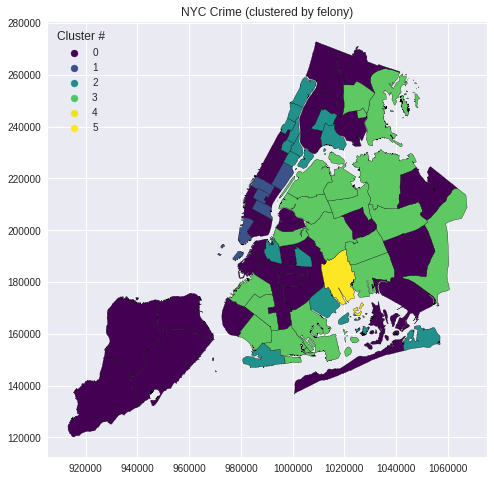

In [27]:
felony_cluster_gdf = precincts.merge(felony_vals, how='inner', left_index=True, right_index=True)
felony_cluster_gdf.plot(column='cluster', cmap='viridis', figsize=(8,8),
                       edgecolor='k', scheme='equal_interval', legend=False);

cmap = matplotlib.cm.get_cmap('viridis')
n, m = Nc_felony, 1.35
colors = [cmap(i) for i in np.arange(0, m, (m + 0.1) / n)] # creates corresponsing color values
for i in range(n):
    plt.scatter([], [], c=colors[i], label=i)
plt.legend(loc=2, title='Cluster #')

pl.title('NYC Crime (clustered by felony)');

**Figure 9:** Above we can see fairly clear clusters of crime in NYC. The obvious outlier here is the 75th Precint, which is in line with our analysis above (see Figure 5). It makes sense that crime in parts of lower-mid Manhattan is slightly different from elsewhere, and that more residential areas further out in Bronx/Queens/Brooklyn are grouped together (we've seen earlier (Figure 5) that they have significantly higher rates of Grand Larceny (Motor Vehicle) than elsewhere). What is most surprising is, as in Figure 8, Statten Island's similar grouping with other parts in the city; because it is much more residential, one may assume it would be an outlier, but the data suggest it actually has many similarities with the other boroughs.  

## 2.7 At last, create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME

I want this to be a function:

        def fitCrime(...):
            ...
            return importance,quality
    
You can run the function with all the precincts, or with the clusters you created above, but discuss the pros and cons of each scheme. You can use any model. I am ok with multi linear regression, but consider other options: trees, SVM, whatever you have explored in PUI, in other classes, in the EC project. I am not looking for a rigorous assessment. If you use statsmodels for regression you can pull any of the diagnostics in the model.summary() (any of the *appropriate* ones). If you use a machine learning method you can assess via cross validation, seeing how much the score changes between test and training sample. Keep in mind that am definitely more interested in the discussion than in the creation of a "good" model. 

**Discuss explicitly which features are important to predict what** 

In [28]:
# Set up the dataframes for a random forest regressor model
model_df = merged_gdf.drop(['Shape_Leng', 'Shape_Area', 'geometry'], axis=1)

train, test = train_test_split(model_df, test_size=0.2, random_state=123)
print('length train: ' +str(len(train)), '\nlength test:  ' + str(len(test)))

length train: 61 
length test:  16


BURGLARY SCORES
Primary Feature: green
Feature importance: 0.38194
Test data R-2 score: 0.21064
Test data Spearman correlation: 0.70588
Test data Spearman p-value: 0.00225
Test data Pearson correlation: 0.63098
Test data Pearson p-value: 0.00877
Pearson 95% Significance: Yes


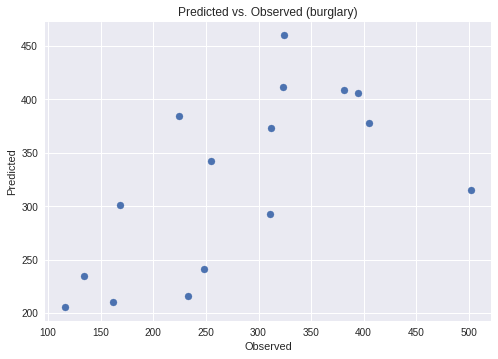

RAPE SCORES
Primary Feature: medianincome
Feature importance: 0.53434
Test data R-2 score: 0.37746
Test data Spearman correlation: 0.85882
Test data Spearman p-value: 2e-05
Test data Pearson correlation: 0.87592
Test data Pearson p-value: 1e-05
Pearson 95% Significance: Yes


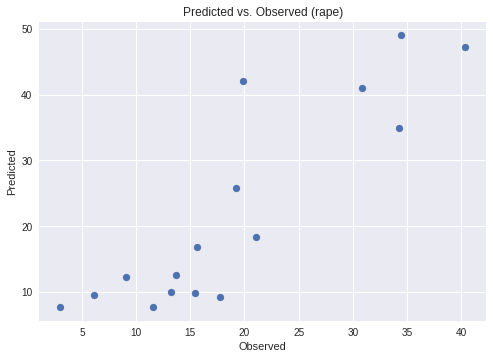

MURDER_AND_NON_NEGL_MANSLAUGHTER SCORES
Primary Feature: unemployment
Feature importance: 0.49378
Test data R-2 score: 0.47782
Test data Spearman correlation: 0.79412
Test data Spearman p-value: 0.00024
Test data Pearson correlation: 0.84872
Test data Pearson p-value: 3e-05
Pearson 95% Significance: Yes


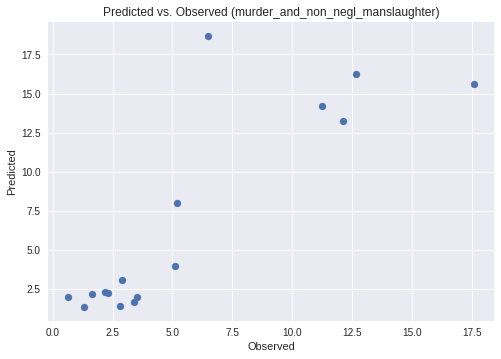

TOTAL_SEVEN_MAJ_FELONIES SCORES
Primary Feature: medianincome
Feature importance: 0.46997
Test data R-2 score: 0.12995
Test data Spearman correlation: 0.56176
Test data Spearman p-value: 0.02354
Test data Pearson correlation: 0.49298
Test data Pearson p-value: 0.05235
Pearson 95% Significance: No


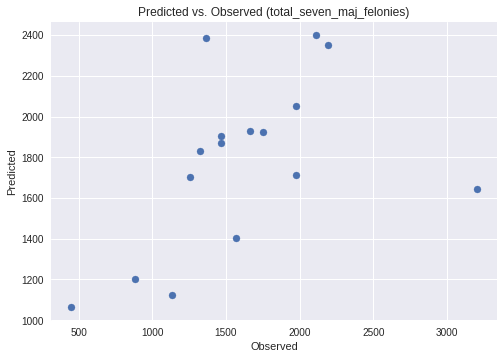

In [29]:
# This is an exploration of a random forest regressor model. Here, I am testing 
# performance, and trying to determine which measures to put in my final function.

# I used http://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/ 
# as a guide for much of this code, modifying accordingly.

features = model_df.columns[:3]
crimes = ['burglary', 'rape', 'murder_and_non_negl_manslaughter', 
          'total_seven_maj_felonies']

for i in crimes:

    X_train = train[features]
    X_test = test[features]
    y_train = train[i]
    y_test = test[i]

# standardizing the scores, as medianincome is much larger than other factors
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, 
                                  columns=X_train.columns.values)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, 
                                 columns=X_test.columns.values)

# fit random forest regression
    forest = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=123)
    forest.fit(X_train, y_train)

# let's look at some performance measures for the model we just produced
    predicted_test = forest.predict(X_test)
    test_score = r2_score(y_test, predicted_test)
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)
    if pearson[1] < 0.05:
        significant = 'Yes'
    else:
        significant = 'No'
    print((str(i) + ' scores').upper())
    print('Primary Feature:', features[(forest.feature_importances_).argmax()])
    print('Feature importance:', round((forest.feature_importances_).max(), 5))
    print('Test data R-2 score:', round(test_score, 5))
    print('Test data Spearman correlation:', round(spearman[0], 5))
    print('Test data Spearman p-value:', round(spearman[1], 5))
    print('Test data Pearson correlation:', round(pearson[0], 5))
    print('Test data Pearson p-value:', round(pearson[1], 5))
    print('Pearson 95% Significance:', significant)

# and finally, let's get a visual to see how we did (straight line is perfect)
    pl.figure()
    pl.scatter(y_test, forest.predict(X_test))
    pl.ylabel('Predicted')
    pl.xlabel('Observed')
    pl.title('Predicted vs. Observed (%s)'%(i))
    pl.show()

**Figure 9:** These plots and figures give us a sense of how strong the model is for each crime type, and what the strongest contributor is from the socioeconomic factors we're working with. More discussion is provided below, as this was promarily exploratory work. 

In [30]:
# disabling warnings, as they severely get in the way of the result here.
import warnings
warnings.filterwarnings('ignore') 


def fitCrime(green, medianincome, unemployment, crime):
    '''
    Given percentage of greenspace, median income, and rate of unemployment, this function
    estimates the total of a specified crime (from Top 7 crimes or a sum of all 7) on a annual
    basis.
    
    It returns the primary contributing feature from the three inputs, and the percentage it 
    contributes vs. the other two (range is 0-1, they all sum to 1, and higher value means 
    greater contribution). Finally, a predicted annual occurance rate for that crime is returned.
    '''
    X_train = train[features]
    y_train = train[crime]

    # standardizing the scores, as medianincome is much larger than other factors
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, 
                                  columns=X_train.columns.values)
    X_test_scaled = scaler.transform([green, medianincome, unemployment])

    # fit random forest regression
    forest = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=123)
    forest.fit(X_train, y_train)
    
    # assign values to return
    predicted_test = forest.predict(X_test_scaled)[0]
    primary_feature = features[(forest.feature_importances_).argmax()]
    feature_importance = (forest.feature_importances_).max()

    return primary_feature, feature_importance, predicted_test

# Set the values with which to predict here.
green = 0.06
medianincome = 100000
unemployment = 0.045
crimes = ['burglary', 'rape', 'murder_and_non_negl_manslaughter', 
          'total_seven_maj_felonies']

# loop for four crimes we want to know
for i in crimes:
    primary_feature, feature_importance, prediction = fitCrime(green, medianincome, unemployment, i)
    print(str(i).upper())
    print('Primary Feature:', primary_feature)
    print('Feature Importance:', round(feature_importance, 5))
    print('Predicted Numer of Given Crime (annual):', round(prediction, 0)) # round to nearest whole,
    print('\n')                                                             # as nobody commits
                                                                            # half a murder.

BURGLARY
Primary Feature: green
Feature Importance: 0.38194
Predicted Numer of Given Crime (annual): 328.0


RAPE
Primary Feature: medianincome
Feature Importance: 0.53434
Predicted Numer of Given Crime (annual): 39.0


MURDER_AND_NON_NEGL_MANSLAUGHTER
Primary Feature: unemployment
Feature Importance: 0.49378
Predicted Numer of Given Crime (annual): 12.0


TOTAL_SEVEN_MAJ_FELONIES
Primary Feature: medianincome
Feature Importance: 0.46997
Predicted Numer of Given Crime (annual): 2194.0




**Discussion:** Greenspace is very weakly the strongest predictor of burglary in our model - perhaps it gives people a space to run away to? Or a decent amount of muggings occur in parks? This seems to make intuitive sense, though one might imagine that other factors are important as well. Median income is the leading predictor for rape as well as all felonies together. Let's look at these seperately. In the case of rape, further analysis is needed - income may be correlated to another factor that has more of an impact, but this an interesting finding nonetheless. As for the total major felonies, it makes sense that income is a strong predictor of crime in general, though as our earlier analysis showed, grand larceny is common in central Manhattan, which has some of the highest incomes in the world. One thing that we should bare in mind when working with demographic data in NYC is that there are large swaths of tourists and workers who come into the city (particularly Manhattan) on a daily basis, and can skew these numbers dramatically. 